In [42]:
import yaml
from yaml.loader import SafeLoader
from socket import gethostname
import numpy as np
import pandas as pd
from sklearn.base import clone
from dev_interaction_util import generate_synthetic_dev_outcomes, generate_synthetic_dev_data, set_up_interactions
from dev_interaction_util import do_scoring_loop, get_best_model, summarize_overall_df_results, do_final_fit, present_model_results, present_results_vs_ground_truth_cors
from ml_util import *
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import linear_model
from ml_util import get_data_for_imputation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import numpy as np
from IPython.display import display, HTML
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFE


In [4]:


print(gethostname())
# Open the file and load the file
with open('config.yml') as f:
    all_yaml = yaml.load(f, Loader=SafeLoader)
    if gethostname() in all_yaml.keys():
        config = all_yaml[gethostname()]
    else:
        config = all_yaml['default']
        
print(config)



dyn-10-109-36-5.wless.uoregon.edu
{'dropbox_data_dir': '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/'}


This notebook is derived from pre_registered_preview.ipynb.

The aim is to look at how the model pipeline does with different sets of ground truths. If we plug in five actual effects, or ten, or twenty, how many are actually identified and how many irrelevant effects are identified?

This can't be too black and white, because of course in real life, teh features are correlated iwth one another. But at least, the features we select to be correlated should _actually be_ the most correlated.

In [5]:
dropbox_data_dir = config['dropbox_data_dir']


# Introduction
This is a pre-registered analysis for measuring moderations of the intervention.

We'll cross-validate the intervention moderations.

For this analysis, we'll try to make predictions based on some synthetic data. we'll take wave 1 data and randomly mix in changes based on our predictors, then try to model how we would predict those things. Finally, we'll make the predictions.

# Load data

In [6]:
data_by_ppt_path = dropbox_data_dir + '/data_by_ppt.csv'
data_codebook_path = dropbox_data_dir + 'data_codebook.csv'




In [7]:
data_by_ppt = pd.read_csv(data_by_ppt_path)
data_codebook = pd.read_csv(data_codebook_path)

In [8]:
#find out which columns in data_by_ppt are missing from the codebook
data_by_ppt.columns.difference(data_codebook['VarName'])


#copy our outcome measures, bf_1 and FFQ_1, into a new dataframe
data_by_ppt['bf_2'] = data_by_ppt.bf_1
#need to decide what sort of FFQ we want to use
data_by_ppt['cancer_promoting_minus_preventing_FFQ_1'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ
data_by_ppt['cancer_promoting_minus_preventing_FFQ_2'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ

# do a report on missing data
analysis_data  = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedPredictor,"VarName"]].copy()
outcome_measures = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedOutcomeMeasure,"VarName"]].copy()

na_values = pd.DataFrame(data_by_ppt.isna().sum())
na_values.columns = ['NA_Count']
na_values['prop_NA'] = na_values.NA_Count / data_by_ppt.shape[0]
data_codebook = data_codebook.merge(na_values, left_on='VarName', right_index=True)

data_codebook.to_csv(dropbox_data_dir + 'data_metadata.csv', index=False)

Need to count the number of valid and missing entries in each of our data predictors

## Converting data to numeric format

In [9]:
one_hot_vals = pd.get_dummies(analysis_data.birthsex_factor)
#there's only two variables here so we can convert this into a dummy variable
analysis_data.drop(columns=['birthsex_factor'], inplace=True)
one_hot_vals.columns = ['birthsex_factor_' + str(col) for col in one_hot_vals.columns]
analysis_data = analysis_data.join(one_hot_vals.iloc[:,1:])

In [10]:
analysis_data

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72,7.0,20.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5125,-0.312500,1
1,2.384615,1.750,89,9.0,22.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440524,0
2,3.384615,2.500,63,9.0,18.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,533.315052,284.375,0.058297,0.247061,-0.8000,-0.190476,0
3,3.076923,2.800,75,NaN,NaN,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.312500,498.167248,103.125,0.027730,0.446583,-0.8000,0.170363,0
4,3.307692,2.750,64,12.0,21.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.562500,626.507764,250.000,0.105660,0.369308,-1.5500,-0.494624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58,18.0,17.0,54.0,0.0,1.0,3.0,1.0,...,-0.690347,1.768485,0.523438,NaN,NaN,NaN,0.357362,-0.0125,-1.008152,1
271,3.692308,3.875,54,17.0,13.0,55.0,2.0,2.0,5.0,0.0,...,-0.511475,-0.234851,0.492188,NaN,NaN,NaN,0.335849,-0.1500,-1.889247,1
272,3.461538,3.125,69,11.0,13.0,53.0,1.0,1.0,6.0,1.0,...,1.335248,0.099038,0.507812,NaN,NaN,NaN,0.273736,NaN,0.516129,1
273,2.846154,3.000,62,15.0,22.0,84.0,0.0,1.0,4.0,1.0,...,0.855379,-0.234851,0.479167,NaN,NaN,NaN,0.401098,-0.9875,-0.151210,0


# Missing data 

Apply missing data imputation to columns including cSES, ACES_sum, ses_aggregate, zipcode_median_income_acs, IMI, mcarthur social standing, based on demographic and self-report predictors.

Based on this experiment, I'm going for Ridge regression with 10 nearest features. The values it imputes are a compromise between simply using the nearest mean, which is conservative when using these values for prediction because it doesn't introduce erroneous variance, but isn't very informative, and then using all available information, which Ridge regression with an unlimited number of features would do. It's a tough choice between this and KNN, which doesn't assume normality. Overall I'm going with KNN, because it picks up on relationships between the two variables while not generating extreme values like KNN seems to do.

In [11]:
imputer = IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100,random_state=0)
analysis_data_imputed = get_data_for_imputation(analysis_data)

#this dataset is already filtered for columns so we don't need to filter those further.
analysis_data_imputed = pd.DataFrame(imputer.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
imputed_datapoint = analysis_data.isna()
# do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,'ridge_10')


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# With feature selection, KBest vs. none

In [142]:

#loops through the different estimators and feature selection methods and does a grid search over all to find the best hyperparameters
def do_hyperparameter_selection_loop(X, y,cv):
    #alpha parameters for Ridge and Lasso
    alpha_10pow_lower = 1
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])
    
    all_cv_results = []

    pipeline_estimator_name = 'estimator'
    feature_selection_name = 'feature_selection'


    #define the param_grid for the estimators
    estimators_to_run = {
        'Ridge':{
            'estimator':linear_model.Ridge,
            'parameters':{'alpha':alpha_range}
        },
        'Lasso':{
            'estimator':linear_model.Lasso,
            'parameters':{'alpha':alpha_range}
        },
        # 'DecisionTreeRegressor':{
        #     'estimator':DecisionTreeRegressor,
        #     'parameters':{
        #         'max_depth':[2, 3,5,10],
        #         'min_samples_split':[5,20,50],
        #         'min_samples_leaf':[5,20,50]
        #     }
        # }             
    }

    for estimator_name,estimator_dict in estimators_to_run.items():
        #param grid for the feature seelction
        #this is here because we need to know the estimator to pass to the feature selector
        feature_selectors_to_run = {
            'None':None,
            'KBest':{
                'selector':SelectKBest(),
                'parameters':{
                    'score_func' : [f_regression], 
                    'k' : [20,50]
                    }
            }#,
            # 'RFE':{
            #     'selector':RFE(linear_model.LinearRegression()),
            #     'parameters':{
            #         'n_features_to_select' : [10,25],
            #         #'verbose':[1],
            #         'step':[5]
            #     }
            # }
        }
        for selector_name, selector_dict in feature_selectors_to_run.items():
        #create the estimator
            if selector_name == 'None':
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = {}
            else:
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (feature_selection_name,selector_dict['selector']), 
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = selector_dict['parameters']

            estimator_param_grid = {(pipeline_estimator_name + '__'+k):v for k,v in estimator_dict['parameters'].items()}
            selector_param_grid = {(feature_selection_name + '__'+k):v for k,v in selector_params.items()}
            #combine the two param grid dictionaries
            full_param_grid = {**selector_param_grid, **estimator_param_grid}
            print(pipeline)
            print(full_param_grid)

            
        
            gs_1 = GridSearchCV(estimator=pipeline, 
                                param_grid = full_param_grid, 
                                cv=cv,scoring='neg_mean_absolute_error',verbose=1)
            gs_1.fit(X,y)
            all_cv_results.append(gs_1)

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })
    
    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }





In [143]:

def present_model_results(X,y, final_fit):
    final_estimator = final_fit.named_steps['estimator']
    
    if hasattr(final_estimator,'coef_'):
        coef = final_estimator.coef_
    else:
        coef = None

    #now check to see if there was a feature selection step,
    #if so, get the feature names from the feature selection step
    if 'feature_selection' in final_fit.named_steps:
        feature_bool = final_fit.named_steps['feature_selection'].get_support(indices=True)
    else:
        feature_bool = [True]*len(X.columns)
    
    feature_names = X.columns[feature_bool]

    #now do a permutation test to do feature importance
    #view the coefficients
    print("doing permutation test on importance; this may take time.")
    permutation_res= [im for im in permutation_importance(final_fit, X, y, n_repeats=10).importances_mean]
    # print(len(feature_names))
    # print(len(permutation_res))
    # print(len(coef))
    
    
    final_results = pd.DataFrame({
        'predictor': feature_names,
        'coef': coef,
        'feature_importance':pd.Series(permutation_res)[feature_bool]
        #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
        #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
    })

    final_results['fa_abs'] = np.abs(final_results.feature_importance)
    final_results = final_results.sort_values('fa_abs',ascending=False)

    if coef is not None:
        selected_features_count = np.sum(final_estimator.coef_!=0)
        print(f"Number of selected features: {selected_features_count}")

    display(HTML(final_results[0:20].to_html()))
    return(final_results)

In [144]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]

### Try out CV with simple gridsearch

scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_loop,
                outer_folds=5)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit, y=outcome_measures_nona['d_bf'])

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results,base_regressors)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 12


,predictor,coef,feature_importance,fa_abs
160,ACES_neglectful_parenting*san,-0.424191,0.033413,0.033413
60,RTFS_f1_minus_f2,-0.394909,0.028802,0.028802
78,BSCS*ni,0.397971,0.028311,0.028311
46,RMQ_locomotion,0.285872,0.019047,0.019047
7,ACES_abuse,-0.213122,0.010822,0.010822
6,ACES_neglectful_parenting,-0.186478,0.010675,0.010675
2,BIS_11,-0.132117,0.007250,0.007250
23,NCS_intellectual_task,-0.176228,0.006808,0.006808
25,NCS_like_responsibility,-0.141830,0.006747,0.006747
26,NCS_thinking_not_exciting,-0.098846,0.004136,0.004136


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:326: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
ACES_neglectful_parenting,-0.186,NaN,-0.424,0.011,NaN,0.033,-0.046,-0.046,-0.476,0.044
RTFS_f1_minus_f2,-0.395,-0.001,NaN,0.029,0.000,NaN,NaN,NaN,NaN,0.029
BSCS,NaN,0.398,NaN,NaN,0.028,NaN,-0.137,0.448,-0.080,0.028
RMQ_locomotion,0.286,0.000,NaN,0.019,0.000,NaN,NaN,NaN,NaN,0.019
ACES_abuse,-0.213,NaN,-0.000,0.011,NaN,0.000,0.147,-0.125,-0.414,0.011
BIS_11,-0.132,NaN,NaN,0.007,NaN,NaN,0.047,-0.528,0.020,0.007
NCS_intellectual_task,-0.176,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,0.007
NCS_like_responsibility,-0.142,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,0.007
NCS_thinking_not_exciting,-0.099,NaN,NaN,0.004,NaN,NaN,NaN,NaN,NaN,0.004
EDM,NaN,0.061,NaN,NaN,0.002,NaN,0.053,0.282,-0.130,0.002


In [37]:
base_regressors

0                         BSCS
6    ACES_neglectful_parenting
4                           RS
5                         TRSQ
1                          EDM
2                       BIS_11
Name: predictor, dtype: object

In [43]:
#import sns

#present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results,base_regressors)


for group_name in ['ichi','ni','san']:

    #print(group_name)
    group_data = predictor_data_nona.loc[group_assignments_nona==group_name,:]
    group_outcomes = outcome_measures_nona.loc[group_assignments_nona==group_name,'d_bf']

    
    
    #get the two-way correlation between data and the outcome column
    #these are what was actually modeled into the data.
    group_correlations = pd.DataFrame({group_name + '_cor':group_data[base_regressors].corrwith(group_outcomes)})
    print(group_correlations)


                           ichi_cor
BSCS                      -0.137476
ACES_neglectful_parenting -0.046428
RS                         0.038831
TRSQ                       0.090684
EDM                        0.053087
BIS_11                     0.046739
                             ni_cor
BSCS                       0.414749
ACES_neglectful_parenting -0.013767
RS                        -0.177482
TRSQ                      -0.245907
EDM                        0.286861
BIS_11                    -0.439706
                            san_cor
BSCS                      -0.010767
ACES_neglectful_parenting -0.262367
RS                         0.304464
TRSQ                       0.318584
EDM                       -0.065328
BIS_11                    -0.032830


Ground Truth:
```
0                              BSCS                0.15
3                               PCS               -0.15
1                               EDM                0.15
2                            BIS_11               -0.15
cancer_promoting_minus_preventing_FFQ_w2
FFQ_v2_Mean_Energy_w2
san
                       feature_name  interaction_effect
4                                RS                0.15
5                              TRSQ                0.15
6         ACES_neglectful_parenting               -0.15
7                        ACES_abuse               -0.15
```

# KBest vs RFE

## Testing a simple feature selection pipelien

In [80]:
my_test_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection', RFE(estimator=linear_model.LinearRegression())),
                ('estimator', Ridge())])

estimator_params = {'alpha':[0.1,0.5,0.9]}
feature_selection_params = {'n_features_to_select':[10,25]}


estimator_param_grid = {(pipeline_estimator_name + '__'+k):v for k,v in estimator_params.items()}
selector_param_grid = {(feature_selection_name + '__'+k):v for k,v in feature_selection_params.items()}
#combine the two param grid dictionaries
full_param_grid = {**selector_param_grid, **estimator_param_grid}
#full_param_grid = {**estimator_param_grid}


In [81]:
full_param_grid

{'feature_selection__n_features_to_select': [10, 25],
 'estimator__alpha': [0.1, 0.5, 0.9]}

In [90]:
predictor_data_nona.shape

(270, 230)

In [91]:
#let's do StandardScaler, RFE, and Ridge outside of the GridSearchCV
#I want to see how it works from one to the next
#no pipeline, just separate steps
#I want to see how it works from one to the next
#no pipeline, just separate steps
scaler = StandardScaler()
scaled_predictor_data = scaler.fit_transform(predictor_data_nona)
rfe = RFE(estimator=linear_model.LinearRegression(),verbose=1,n_features_to_select=10,step=4)
rfe.fit(scaled_predictor_data,outcome_measures_nona['d_bf'])
rfe_results = pd.DataFrame({'predictor':predictor_data_nona.columns,'rfe_support':rfe.support_,'rfe_ranking':rfe.ranking_})

Fitting estimator with 230 features.
Fitting estimator with 226 features.
Fitting estimator with 222 features.
Fitting estimator with 218 features.
Fitting estimator with 214 features.
Fitting estimator with 210 features.
Fitting estimator with 206 features.
Fitting estimator with 202 features.
Fitting estimator with 198 features.
Fitting estimator with 194 features.
Fitting estimator with 190 features.
Fitting estimator with 186 features.
Fitting estimator with 182 features.
Fitting estimator with 178 features.
Fitting estimator with 174 features.
Fitting estimator with 170 features.
Fitting estimator with 166 features.
Fitting estimator with 162 features.
Fitting estimator with 158 features.
Fitting estimator with 154 features.
Fitting estimator with 150 features.
Fitting estimator with 146 features.
Fitting estimator with 142 features.
Fitting estimator with 138 features.
Fitting estimator with 134 features.
Fitting estimator with 130 features.
Fitting estimator with 126 features.
F

In [85]:
rfe_results

,predictor,rfe_support,rfe_ranking
0,BSCS,False,49
1,EDM,True,1
2,BIS_11,False,4
3,PCS,False,47
4,RS,False,72
...,...,...,...
225,SST_PostErrorSlowW1_mean*san,False,36
226,SST_mean_ssrt_0*san,False,87
227,ROC_Crave_Regulate_Minus_Look*san,True,1
228,WTP_unhealthy_minus_healthy*san,False,23


## Full model with RFE

In [12]:

#loops through the different estimators and feature selection methods and does a grid search over all to find the best hyperparameters
def do_hyperparameter_selection_loop(X, y,cv):
    #alpha parameters for Ridge and Lasso
    alpha_10pow_lower = 1
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])
    
    all_cv_results = []

    pipeline_estimator_name = 'estimator'
    feature_selection_name = 'feature_selection'


    #define the param_grid for the estimators
    estimators_to_run = {
        'Ridge':{
            'estimator':linear_model.Ridge,
            'parameters':{'alpha':alpha_range}
        },
        'Lasso':{
            'estimator':linear_model.Lasso,
            'parameters':{'alpha':alpha_range}
        },
        'DecisionTreeRegressor':{
            'estimator':DecisionTreeRegressor,
            'parameters':{
                'max_depth':[2, 4],
                'min_samples_split':[20,50],
                'min_samples_leaf':[20,50]
            }
        }             
    }

    for estimator_name,estimator_dict in estimators_to_run.items():
        #param grid for the feature seelction
        #this is here because we need to know the estimator to pass to the feature selector
        feature_selectors_to_run = {
            'None':None,
            'KBest':{
                'selector':SelectKBest(),
                'parameters':{
                    'score_func' : [f_regression], 
                    'k' : [20,50]
                    }
            },
            'RFE':{
                'selector':RFE(linear_model.LinearRegression()),
                'parameters':{
                    'n_features_to_select' : [10,25],
                    #'verbose':[1],
                    'step':[5]
                }
            }
        }
        for selector_name, selector_dict in feature_selectors_to_run.items():
        #create the estimator
            if selector_name == 'None':
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = {}
            else:
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (feature_selection_name,selector_dict['selector']), 
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = selector_dict['parameters']

            estimator_param_grid = {(pipeline_estimator_name + '__'+k):v for k,v in estimator_dict['parameters'].items()}
            selector_param_grid = {(feature_selection_name + '__'+k):v for k,v in selector_params.items()}
            #combine the two param grid dictionaries
            full_param_grid = {**selector_param_grid, **estimator_param_grid}
            print(pipeline)
            print(full_param_grid)

            
        
            gs_1 = GridSearchCV(estimator=pipeline, 
                                param_grid = full_param_grid, 
                                cv=cv,scoring='neg_mean_absolute_error',verbose=1)
            gs_1.fit(X,y)
            all_cv_results.append(gs_1)

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })
    
    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }





In [13]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.15
custom_interaction_effects_g1[1] = 0.15
custom_interaction_effects_g1[2] = -0.15
custom_interaction_effects_g1[3] = -0.15

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.15
custom_interaction_effects_g2[5] = 0.15
custom_interaction_effects_g2[6] = -0.15
custom_interaction_effects_g2[7] = -0.15

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]

### Try out CV with simple gridsearch

scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_loop,
                outer_folds=5)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit, y=outcome_measures_nona['d_bf'])

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results,base_regressors)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 6


,predictor,coef,feature_importance,fa_abs
76,ni,2.495645,0.596439,0.596439
80,BIS_11*ni,-2.162378,0.445639,0.445639
160,ACES_neglectful_parenting*san,-0.851155,0.069057,0.069057
161,ACES_abuse*san,-0.286740,0.007762,0.007762
163,ACES_divorced_separated*san,0.122512,0.003739,0.003739
164,ACES_household_dysfunction*san,0.011257,0.000257,0.000257
127,SRHI_healthy*ni,0.000000,0.000000,0.000000
128,SRHI_unhealthy*ni,0.000000,0.000000,0.000000
137,SRHI_healthy_minus_unhealthy*ni,-0.000000,0.000000,0.000000
162,ACES_sum*san,0.000000,0.000000,0.000000


/Users/benjaminsmith/Google Drive/oregon/code/DEV_scripts/analyses/intervention_moderation/dev_interaction_util.py:341: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
ni,2.496,NaN,NaN,0.596,NaN,NaN,NaN,NaN,NaN,0.596
BIS_11,NaN,-2.162,NaN,NaN,0.446,NaN,0.047,-0.528,0.020,0.446
ACES_neglectful_parenting,NaN,NaN,-0.851,NaN,NaN,0.069,-0.046,-0.046,-0.476,0.069
ACES_abuse,NaN,NaN,-0.287,NaN,NaN,0.008,0.147,-0.125,-0.414,0.008
ACES_divorced_separated,NaN,NaN,0.123,NaN,NaN,0.004,NaN,NaN,NaN,0.004


Well, that actually worked. It seems to be left with an $R^2$ of 0.07, which is reasonably good performance, I think.

I now want to re-run with a more ecologically valid design to see if that works.

We probably realistically will only pick up on around 3 features per item (given the size of the dataset), and we would expect their correlations to be not much higher than r=0.3. So let's design a simulated dataset that looks like that, and re-run.

# Repeat with 4 features with r around 0.3

In [72]:

#loops through the different estimators and feature selection methods and does a grid search over all to find the best hyperparameters
def do_hyperparameter_selection_loop_simple(X, y,cv):
    #alpha parameters for Ridge and Lasso
    alpha_10pow_lower = 1
    alpha_10pow_upper = 0
    alpha_increments=1
    alpha_range = np.concatenate([np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1)),
        [0.2,0.4,0.6,0.8,1.0]])
    
    all_cv_results = []

    pipeline_estimator_name = 'estimator'
    feature_selection_name = 'feature_selection'


    #define the param_grid for the estimators
    estimators_to_run = {
        'Ridge':{
            'estimator':linear_model.Ridge,
            'parameters':{'alpha':alpha_range}
        },
        # 'Lasso':{
        #     'estimator':linear_model.Lasso,
        #     'parameters':{'alpha':alpha_range}
        # },
        'DecisionTreeRegressor':{
            'estimator':DecisionTreeRegressor,
            'parameters':{
                'max_depth':[2, 4],
                'min_samples_split':[20,50],
                'min_samples_leaf':[20,50]
            }
        }             
    }

    for estimator_name,estimator_dict in estimators_to_run.items():
        #param grid for the feature seelction
        #this is here because we need to know the estimator to pass to the feature selector
        feature_selectors_to_run = {
            # 'None':None,
            'KBest':{
                'selector':SelectKBest(),
                'parameters':{
                    'score_func' : [f_regression], 
                    'k' : [20,50]
                    }
            }#,
            # 'RFE':{
            #     'selector':RFE(linear_model.LinearRegression()),
            #     'parameters':{
            #         'n_features_to_select' : [10,25],
            #         #'verbose':[1],
            #         'step':[5]
            #     }
            # }
        }
        for selector_name, selector_dict in feature_selectors_to_run.items():
        #create the estimator
            if selector_name == 'None':
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = {}
            else:
                pipeline = Pipeline([('scaler',StandardScaler()),
                                     (feature_selection_name,selector_dict['selector']), 
                                     (pipeline_estimator_name,estimator_dict['estimator']())])
                selector_params = selector_dict['parameters']

            estimator_param_grid = {(pipeline_estimator_name + '__'+k):v for k,v in estimator_dict['parameters'].items()}
            selector_param_grid = {(feature_selection_name + '__'+k):v for k,v in selector_params.items()}
            #combine the two param grid dictionaries
            full_param_grid = {**selector_param_grid, **estimator_param_grid}
            print(pipeline)
            print(full_param_grid)

            
        
            gs_1 = GridSearchCV(estimator=pipeline, 
                                param_grid = full_param_grid, 
                                cv=cv,scoring='neg_mean_absolute_error',verbose=1)
            gs_1.fit(X,y)
            all_cv_results.append(gs_1)

    #create a dataframe with the best parameters, best mean_test_score, and name of the model

    best_params_df = pd.DataFrame({
        'model': [cv_result.estimator for cv_result in all_cv_results],
        'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
        'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
        'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
        'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
        })
    
    best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

    best_model = clone(best_params_df['model'][0])
    best_model_params = best_params_df['best_raw_params'][0]
    best_model.set_params(**best_model_params)

    return {
        'best_model': best_model,
        'best_params_df':best_params_df,
        'raw_cv_results':all_cv_results
    }





In [86]:

#set np random seed
np.random.seed(3161527)

group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])

#synthetic outcomes
outcome_measures = generate_synthetic_dev_outcomes(outcome_measures)

# add synthetic primary and interaction effects


#set up the interaction effects
#0.08 will give us correlations around 0.3 between the interaction effects and the outcome
custom_interaction_effects_g1 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g1[0] = 0.08
custom_interaction_effects_g1[1] = 0.08
custom_interaction_effects_g1[2] = -0.08

custom_interaction_effects_g2 = [0]*analysis_data_imputed.shape[1]
custom_interaction_effects_g2[4] = 0.08
custom_interaction_effects_g2[5] = 0.08
custom_interaction_effects_g2[6] = -0.08

custom_interaction_effects = {'ni':custom_interaction_effects_g1,'san':custom_interaction_effects_g2}



synthetic_data = generate_synthetic_dev_data(analysis_data_imputed, group_assignments,outcome_measures, group_interaction_effects = custom_interaction_effects)
interaction_effect_df = synthetic_data['X_weights']
outcome_measures = synthetic_data['y']

# Set up outcome measures and group assignment one-hot

outcome_measures = calculate_outcome_changes(outcome_measures)
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

predictor_data = set_up_interactions(analysis_data_imputed, group_assignment_onehots)


#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]
group_assignment_onehots_nonan = group_assignment_onehots.loc[~outcome_nas,:]
group_assignments_nona = group_assignments[~outcome_nas]

### Try out CV with simple gridsearch

scoring_data = do_scoring_loop(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], 
                groups = group_assignments_nona, 
                hyperparameter_selection_on_fold=do_hyperparameter_selection_loop,
                outer_folds=5)

scores = scoring_data['scores']
best_models = scoring_data['best_models']
best_params_df_list = scoring_data['best_params_df_list']
raw_cv_results_list = scoring_data['raw_cv_results_list']

print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)



best_model = get_best_model(summarize_overall_df_results(raw_cv_results_list))
final_fit = do_final_fit(X=predictor_data_nona, y= outcome_measures_nona['d_bf'], final_model=best_model)
final_results = present_model_results(X=predictor_data_nona, final_fit=final_fit, y=outcome_measures_nona['d_bf'])

#print rows of final_results where feature_name is the list of features to check
base_regressors = interaction_effect_df.predictor[interaction_effect_df.interaction_effect!=0]
regressors_to_check = [x+y for y in ['','*ni','*san'] for x in base_regressors]
final_results['planned_regression'] = final_results['predictor'].isin(regressors_to_check)

present_results_vs_ground_truth_cors(predictor_data_nona,outcome_measures_nona,group_assignments_nona,final_results,base_regressors)

['ni' 'san']
[1.28335298 0.42953651]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi' '

doing permutation test on importance; this may take time.
Number of selected features: 3


,predictor,coef,feature_importance,fa_abs
78,BSCS*ni,0.585455,0.054570,0.054570
160,ACES_neglectful_parenting*san,-0.074960,0.001736,0.001736
49,SRHI_healthy,0.010187,0.000442,0.000442
127,SRHI_healthy*ni,0.000000,0.000000,0.000000
128,SRHI_unhealthy*ni,-0.000000,0.000000,0.000000
137,SRHI_healthy_minus_unhealthy*ni,0.000000,0.000000,0.000000
161,ACES_abuse*san,0.000000,0.000000,0.000000
162,ACES_sum*san,0.000000,0.000000,0.000000
163,ACES_divorced_separated*san,0.000000,0.000000,0.000000
164,ACES_household_dysfunction*san,0.000000,0.000000,0.000000


/var/folders/cj/4mb6t1f906j397tj71pxfxz00000gn/T/ipykernel_4177/1286833038.py:35: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_vs_cors = final_results_wide.merge(group_correlations, left_index=True, right_index=True, how='outer')


,"(coef, base)","(coef, ni)","(coef, san)","(feature_importance, base)","(feature_importance, ni)","(feature_importance, san)",ichi_cor,ni_cor,san_cor,abs_effect_sum
BSCS,NaN,0.585,NaN,NaN,0.055,NaN,-0.137,0.350,0.008,0.055
ACES_neglectful_parenting,NaN,NaN,-0.075,NaN,NaN,0.002,-0.046,-0.017,-0.218,0.002


In [88]:
print("scores:")
print(scores)
overall_score = np.mean(scores)
print("overall_score:")
print(overall_score)


scores:
[0.011174447369400098, -0.0050640904196535, -0.04998814452885969, 0.020264408412723145, -0.029100996395088785]
overall_score:
-0.010542875112295746


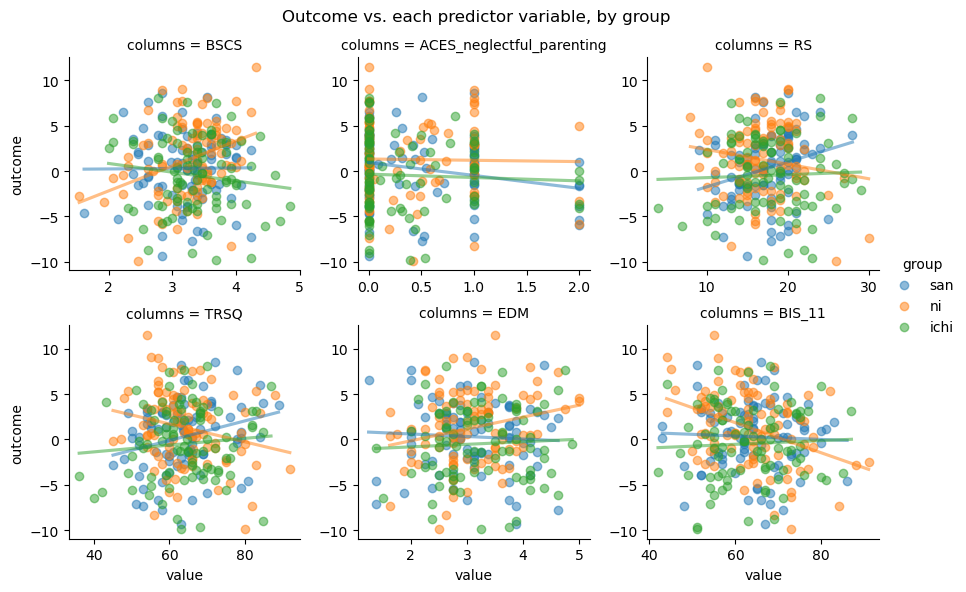

In [89]:



# # Great--now print a scatterplot of the series group_outcomes and each column of the dataframe group_data
# # do this separately for each group
# for group_name in ['ichi','ni','san']:

#     #print(group_name)
#     group_data = predictor_data_nona.loc[group_assignments_nona==group_name,base_regressors]
#     group_outcomes = outcome_measures_nona.loc[group_assignments_nona==group_name,'d_bf']


graph_data = predictor_data_nona.loc[:,base_regressors].copy()
graph_data['outcome'] = outcome_measures_nona.loc[:,'d_bf']
graph_data['group'] = group_assignments_nona

df_melted = pd.melt(graph_data, id_vars=['outcome', 'group'], var_name='columns')


# Create a FacetGrid with scatter plots
#wrap the facetgrid so that the rows and columns are equal, as much as is possible
#allow the axes for each facet to vary freely to best display data in each facet
#be sure to allow enough room for the title
g = sns.FacetGrid(df_melted, col='columns', hue='group', col_wrap=3, height=3, aspect=1, sharex=False, sharey=False,margin_titles=True)
#do the scatterplot; include a trendline for each group
g.map(sns.regplot,  'value','outcome', ci=None, scatter_kws={'alpha':0.5}, line_kws={'alpha':0.5})
# Add a title for the whole plot
g.fig.suptitle('Outcome vs. each predictor variable, by group')

# Add a legend
g.add_legend()

plt.subplots_adjust(top=0.9)
# Show the plot
plt.show()


# Conclusion so far

The feature selection applied here hasn't helped very much. That surprises me because in test_limited_predictors, I got clear evidence that cutting down irrelevant predictors improved model performance.

One reason might be that we've actually cut down on useful predictors--unlike in `test_limited_predictors.ipynb`, we can't cheat by removing predictors we know to be irrelevant. That means we're left with less information in the model itself.

We've only really tried SelectKBest(); there might be other feature selection mechanisms that could do the job. But I don't know yet.